In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import os
import tarfile
import scipy.io as sio
import numpy as np
import random
import cv2

In [2]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='/tmp/car_ims'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i][8:]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)

        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]

        # margins of 16 pixels (Crop image according to a given bounding box)
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/tmp/car_ims/train/'
        else:
            dst_folder = '/tmp/car_ims/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        dst_image = src_image[y1:y2, x1:x2]
        cv2.imwrite(dst_path, dst_image)

### Download and Separate Data

We first need to download the data from a remote server and seperate the data into training and testing sets. Note that you only need to download the data once, if you have downloaded the data before do not run the code in this section.

In [3]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz \
  -O /tmp/car_ims.tgz

--2022-08-12 14:50:16--  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘/tmp/car_ims.tgz’

/tmp/car_ims.tgz    100%[===================>]   1.82G  36.4MB/s    in 53s     

2022-08-12 14:51:09 (35.2 MB/s) - ‘/tmp/car_ims.tgz’ saved [1956628579/1956628579]



In [4]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat \
  -O /tmp/cars_annos.mat

--2022-08-12 14:51:09--  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘/tmp/cars_annos.mat’

/tmp/cars_annos.mat 100%[===================>] 385.23K   571KB/s    in 0.7s    

2022-08-12 14:51:10 (571 KB/s) - ‘/tmp/cars_annos.mat’ saved [394471/394471]



In [5]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat \
  -O /tmp/cars_test_annos.mat

--2022-08-12 14:51:10--  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘/tmp/cars_test_annos.mat’

/tmp/cars_test_anno 100%[===================>] 181.40K   488KB/s    in 0.4s    

2022-08-12 14:51:11 (488 KB/s) - ‘/tmp/cars_test_annos.mat’ saved [185758/185758]



In [6]:
!rm -rf /tmp/car_ims/train/
!rm -rf /tmp/car_ims/test/
!rm -rf /tmp/car_ims/valid/

Unzip the compressed data. (You do not need to understand how this works)

In [7]:
local_tar = '/tmp/car_ims.tgz'
my_tar = tarfile.open(local_tar)
my_tar.extractall('/tmp')
my_tar.close()

In [8]:
car_annotation= sio.loadmat('/tmp/cars_annos.mat')

annotations = car_annotation['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
labels = []
bboxes  = []
for annotation in annotations:
  bbox_x1 = annotation[0][1][0][0]
  bbox_y1 = annotation[0][2][0][0]
  bbox_x2 = annotation[0][3][0][0]
  bbox_y2 = annotation[0][4][0][0]

  class_id = annotation[0][5][0][0]
  bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
  labels.append(f'{class_id:06}')

  file_name = annotation[0][0][0]
  class_ids.append(class_id)
  fnames.append(file_name)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

save_train_data(fnames, labels, bboxes)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


### Create a data generator

In [9]:
datagen = ImageDataGenerator()
train_iter = datagen.flow_from_directory('/tmp/car_ims/train/', class_mode='categorical', batch_size=32)
test_iter = datagen.flow_from_directory('/tmp/car_ims/valid/', class_mode='categorical', batch_size=32)

Found 12948 images belonging to 196 classes.
Found 3237 images belonging to 196 classes.


## Visualize Images:

(256, 256, 3)


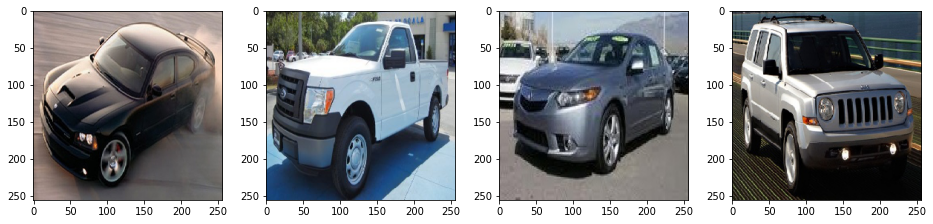

In [10]:
# Visualize images
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

#Plots our figures


batch = train_iter.next() #returns an array whose first index is your batch of 32 images
print(batch[0][0].shape) #we take the list of 32 images out of the array and then access the 1st image to get its shape
print(batch[0][0]) #Observe that all values are float values between 0 and 255
for i in range(1,5):
   plt.subplot(4, 4, i)
   plt.imshow((batch[0][i]).astype(int)) #convert float values to int as imshow only works with int values
plt.show()

### Build Model

In [11]:
# TODO
# BUild your model